In [2]:
from astroquery.gaia import Gaia
from scipy import stats

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import os

In [3]:
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')

In [4]:
p = 1/2500

local_star_query = f"""
                    SELECT * FROM gaiadr3.gaia_source AS gaia
                    WHERE 
                    parallax < {p} AND
                    gaia.radial_velocity IS NOT NULL AND
                    gaia.b BETWEEN -30 AND 30 AND
                    random_index BETWEEN 0 AND 10000000
                    """

#job = Gaia.launch_job_async(local_star_query, dump_to_file=True, output_format='fits')

In [5]:
#results = job.get_results()
#results['designation'] = results['designation'].astype(str)

#df = results.to_pandas()
#df[['source_id', 'designation', 'source_id', 'ra', 'dec', 'parallax', 'pm', 'pmra', 'pmdec', 'radial_velocity', 'rv_nb_transits', 'rv_nb_deblended_transits']]

In [18]:
premade_testing_data = "data/GaiaDR3_poege5_DoddQuality_2p5kpc.parquet"
df_test = pl.read_parquet(premade_testing_data).select('vT')

In [ ]:
# df_test = df.sample(2e6, seed=255897)
# del df

In [105]:
# df_test.write_parquet("data/GaiaDR3_poege5_DoddQuality_2p5kpc_random_sample.parquet")
#vdf_test = pl.read_parquet("data/GaiaDR3_poege5_DoddQuality_2p5kpc_random_sample.parquet")
df_test = df_test.with_columns(
    (pl.col('vT')-220).alias('vT_adj'))
#print(df_test.filter(pl.col('vT_adj')))
filtered_vT = df_test.filter(pl.col('vT_adj').is_between(-150, 75)).select('vT_adj').to_numpy()
min_val = abs(filtered_vT.min())+1e-6

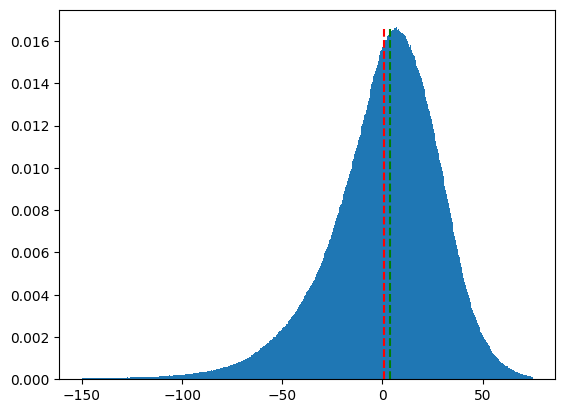

In [100]:
N_bins = 500

fig, ax = plt.subplots(1, 1)

counts, bins = np.histogram(filtered_vT, bins=N_bins, density=True)

bins = (bins[1:] + bins[:-1]) / 2

ax.vlines([np.mean(filtered_vT), np.median(filtered_vT)], 0, counts.max(), colors=['r', 'g'], linestyles='dashed')

ax.hist(filtered_vT, bins=N_bins, density=True)
#ax.plot(bins, counts, '.')
#ax.set_yscale('log')
plt.show()

In [92]:
skew_params = stats.skewnorm.fit(filtered_vT)
skew_params

(np.float64(-2.495049823499495),
 np.float64(31.104092340304177),
 np.float64(41.319782311961944))

In [93]:
lognorm_params = stats.lognorm.fit(filtered_vT+min_val+1e-6)
lognorm_params 

(np.float64(1.361754796279934e-05),
 -2061327.0207486218,
 np.float64(2061477.8043927837))

In [94]:
norm_params = stats.norm.fit(filtered_vT)
norm_params

(np.float64(0.7844221090322235), np.float64(28.072110318520387))

In [95]:
gennorm_params = stats.gennorm.fit(filtered_vT)
gennorm_params

(np.float64(1.394490960554928),
 np.float64(2.748157248010765),
 np.float64(30.497849247207785))

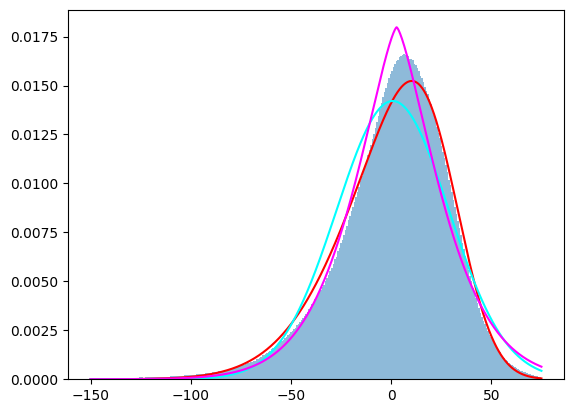

In [96]:
fig, ax = plt.subplots(1, 1)

sample_vT = np.linspace(-150, 75, 1000)

ax.plot(sample_vT, stats.skewnorm.pdf(sample_vT, *skew_params), c='r')
#ax.plot(sample_vT-min_val-1e-6, stats.lognorm.pdf(sample_vT, *lognorm_params), c='orange')
ax.plot(sample_vT, stats.norm.pdf(sample_vT, *norm_params), c='cyan')
ax.plot(sample_vT, stats.gennorm.pdf(sample_vT, *gennorm_params), c='magenta')
ax.hist(filtered_vT, bins=N_bins, density=True, alpha=0.5)

#ax.set_yscale('log')

plt.show()

In [106]:
from scipy.optimize import curve_fit

def skew_norm_func(x, a, loc, scale):
    return stats.skewnorm.pdf(x, a, loc, scale)

def log_norm_func(x, s, loc, scale):
    return stats.lognorm.pdf(x, s, loc, scale)

def norm_func(x, loc, scale):
    return stats.norm.pdf(x, loc, scale)

def gennorm_func(x, beta, loc, scale):
    return stats.gennorm.pdf(x, beta, loc, scale)

def gamma_func(x, a, loc, scale):
    return stats.gamma.pdf(x, a, loc, scale)

skew_popt, skew_pcov = curve_fit(skew_norm_func, bins, counts, p0=[-0.85044108, 0, 40])
log_popt, log_pcov = curve_fit(log_norm_func, bins+min_val, counts)
norm_popt, norm_pcov = curve_fit(norm_func, bins, counts)
gennorm_popt, gennorm_pcov = curve_fit(gennorm_func, bins, counts)
gamma_popt, gamma_pcov = curve_fit(gamma_func, bins, counts)
skew_popt, log_popt, norm_popt, gennorm_popt, gamma_popt

(array([-2.04420581, 28.16688388, 36.58048428]),
 array([2.98917062, 1.57499272, 1.22718983]),
 array([ 5.38517124, 24.5596461 ]),
 array([ 1.6600913 ,  5.59341649, 32.9969164 ]),
 array([0.77562621, 0.07478927, 1.31512487]))

In [102]:
stats.skew(filtered_vT), stats.kurtosis(filtered_vT)

(array([-0.85044108]), array([1.71416338]))

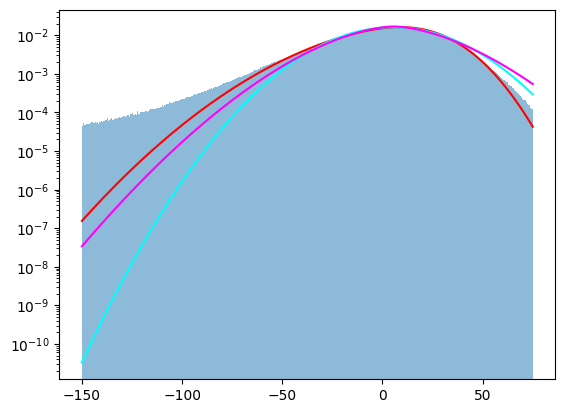

In [110]:
fig, ax = plt.subplots(1, 1)

sample_vT = np.linspace(-150, 75, 1000)

ax.plot(sample_vT, skew_norm_func(sample_vT, *skew_popt), c='r')
# ax.plot(sample_vT, log_norm_func(sample_vT, *log_popt), c='orange')
ax.plot(sample_vT, norm_func(sample_vT, *norm_popt), c='cyan')
ax.plot(sample_vT, gennorm_func(sample_vT, *gennorm_popt), c='magenta')
# ax.plot(sample_vT, gamma_func(sample_vT, *gamma_popt), c='orange')
ax.hist(filtered_vT, bins=N_bins, density=True, alpha=0.5)

ax.set_yscale('log')

plt.show()

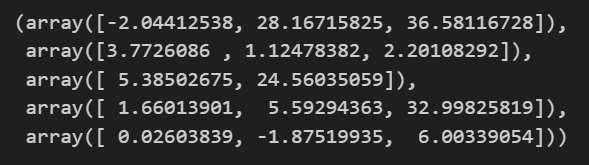

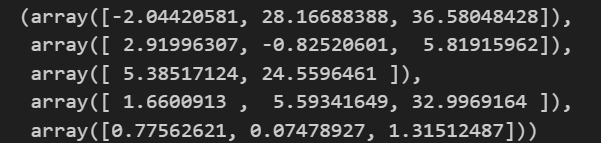